# Multi-class Classification and Neural Networks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.optimize as opt
import random
%matplotlib inline


## 1.1 Dataset

In [5]:
d = loadmat('Data/ex3data1.mat')

In [3]:
X, y = d['X'], d['y']
X = np.insert(X, 0, 1, axis=1)
X.shape, y.shape

((5000, 401), (5000, 1))

The MINST data is a set of 5000 training examples where each example is a 20x20 pixel greyscale image of digits (400 rows/features). In the X key, each of the pixel is represented by a floating point number indicating intensity. In the y key, each of the examples is the label for the training set. (Note that "0" is labeled as "10"). As before, I added a column of 1's for the bias vector.

## 1.2 Visualizing the data

I want to see random images of the data. The Octave function to display the data is included in the assignment, but I've found someone who has translated it to python.(https://github.com/kaleko/CourseraML/blob/master/ex3/ex3.ipynb)  

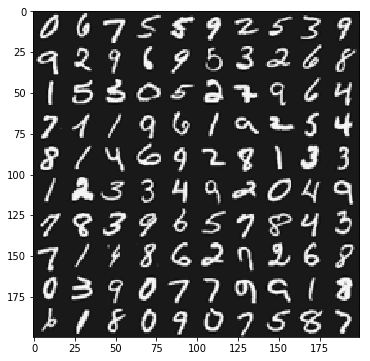

In [4]:
from graph import displayData
displayData(X)

## 1.3 Vectorizing Regularized Logistic Regression

The cost function is the same as the previous assignment since it was already vectorized. For the graident, it is derived that X.T * error added with a regulerized term for all of theta except for theta zero. X is transposed so each feature is a row and all the training examples multiply their corresponding example (i) in the error vector, so gradient is now a vector with the length of number of features.

In [ ]:
def sigmoid(z):
    g = 1 / (1 + np.exp(-z))
    return g

In [ ]:
def lrCostFunction(theta, X, y, my_lambda):
    m = float(len(X))
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    #cost function:
    term1 = np.multiply(-y,np.log(sigmoid(X*theta.T)))
    term2 = np.multiply((1-y),np.log(1-sigmoid(X*theta.T)))
    reg = np.power(theta[:,1:theta.shape[1]],2)
    J = np.sum(term1-term2)/m + (my_lambda/(2.0*m) * np.sum(reg))
    
    return J

In [ ]:
def gradient (theta, X, y, my_lambda):
    m = float(len(X))
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    
    #gradient:
    error = sigmoid(X * theta.T) - y
    g = (X.T * error /(m)).T + ((my_lambda/m) * theta)
    g[0,0] = np.sum(np.multiply(error, X[:,0])) / m
    
    return g

In [ ]:
#Testing the function with test parameters and inputs
theta_t = np.array([-2, -1, 1, 2])
X_t = np.array(np.arange(1,16)/10.0).reshape(3,5).T
X_t = np.insert(X_t, 0, 1, axis=1)
y_t = np.array([[1],[0],[1],[0],[1]])
lambda_t = 3
J = lrCostFunction(theta_t, X_t, y_t, lambda_t)
grad = gradient(theta_t, X_t, y_t, lambda_t)
print('Cost: %r') %J
print('Expected cost: 2.534819')
print('Gradients:          %s') %grad
print('Expected gradients: [[ 0.146561   -0.548558    0.724722    1.398003 ]]')


## 1.4 One-vs-all Classification

For the one vs all classification, I compare each class against all classes as one class 10 times. I used the truncated Newton method because it is quick for large data, but I could've very well used the conjugated gradient method.

In [ ]:
def oneVsAll(X, y, num_labels, my_lambda):
    m = X.shape[0]
    n = X.shape[1]-1
    all_theta = np.zeros((num_labels,n+1))
    for K in range(1, num_labels + 1):
        theta = (np.zeros(n+1))
        y_logical = np.array([1 if j == K else 0 for j in y]).reshape(m,1)
        opt_theta = opt.minimize(fun=lrCostFunction, x0=theta.T, \
                                 args=(X,y_logical,my_lambda), \
                                 method='TNC', jac=gradient).x
        all_theta[K-1,:] = opt_theta
    return all_theta

In [ ]:
all_theta = oneVsAll(X, y, 10, 1)
print ('All theta shape: %s') % (all_theta.shape,)

## 1.4.1 One-vs-all Prediction  

The prediction function applies the all_theta to the input variable in sigmoid, which returns a matrix of (5000,10), then takes the column index with the highest probability for each row. I added it by one because of zero indexing.

In [ ]:
def predict(theta, X):
    theta = np.matrix(theta)
    X = np.matrix(X)
    sig = sigmoid(X*theta.T) #(5000,10)
    p = np.argmax(sig, axis=1) + 1  #(5000,1)
    return p

def accuracy(theta, X, y):
    p = predict(theta, X)
    right = sum([1 if (est == actual) else 0 for (est,actual) in zip(p,y)])
    a = float(right)/len(X) * 100.0
    return float(a)
print("The accuracy of this model is %r%%") % accuracy(all_theta,X,y)

# 2. Neural Networks

## 2.1 Model Representation

In [ ]:
weights = loadmat('Data/ex3weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']
print ('theta 1: %r\ntheta 2: %r') % (theta1.shape, theta2.shape)

## 2.2 Feedforward Propagation and Prediction 

Now I'm going to implement a feedforward propagation with the provided thetas and return an output matrix with 10 classes for each of the training examples.

In [ ]:
def Feedforward_Propagation(theta1, theta2, X):
    X = np.matrix(X)
    theta1 = np.matrix(theta1)
    theta2 = np.matrix(theta2)

    a2 = sigmoid(X * theta1.T) 
    a2 = np.insert(a2, 0, 1, axis = 1) #Hidden layer with bias is (5000,26) 
    a3 = sigmoid(a2 * theta2.T) #Output layer is (5000,10)
    
    return a3

To see how accurate the parameters are, I repeated the above steps and found the indexes with the highest probability and compare it to y.

In [ ]:
def predict_nn(theta1, theta2, X):
    X = np.matrix(X)
    theta1 = np.matrix(theta1)
    theta2 = np.matrix(theta2)
    a3 = Feedforward_Propagation(theta1, theta2, X)
    p = np.argmax(a3, axis =1) + 1
    return p

def accuracy_nn(theta1, theta2, X, y):
    p = predict_nn(theta1,theta2,X)
    right = sum([1 if (est == actual) else 0 for (est,actual) in zip(p,y)])
    a = float(right)/len(X) * 100.0
    return float(a)
print("The accuracy of this model is %r%%") % accuracy_nn(theta1, theta2, X, y)

The accuracy is as expected. Even though this is only a one layer neural net, it still performed better than the logistical regression because it is a linear model.

## Results

Let's see how we did visually in 20 random samples. Remember 0 means 10 in the images.

In [ ]:
estimate = predict_nn(theta1,theta2,X)
for count in xrange(50):
    indexes = random.choice(range(0,4999))
    fig = plt.figure(figsize=(2,2))
    img = scipy.misc.toimage( getDatumImg(X[indexes]) )
    plt.imshow(img,cmap = cm.Greys_r)
    predicted = int(estimate[indexes])
    plt.title('Predicte #: %d'%predicted, fontsize=12, fontweight='bold')